In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline

In [2]:
# Load the dataset
data = pd.read_csv("cleaned_data.csv")

In [3]:
# Map 'Yes' to 1 and 'No' to 0 in the 'Heart_Stroke' column
data['Heart_Stroke'] = data['Heart_Stroke'].map({'Yes': 1, 'No': 0})

In [4]:
# Label encoding for the 'Gender' column
label_encoder = LabelEncoder()
data['Gender'] = label_encoder.fit_transform(data['Gender'])

# Label encoding for binary categorical columns
label_encoder = LabelEncoder()
data['BPMeds'] = label_encoder.fit_transform(data['BPMeds'])
data['prevalentStroke'] = label_encoder.fit_transform(data['prevalentStroke'])
data['prevalentHyp'] = label_encoder.fit_transform(data['prevalentHyp'])

# One-hot encoding for the 'education' column
data = pd.get_dummies(data, columns=['education'], drop_first=True)


In [5]:
# Select features and target
X = data.drop('Heart_Stroke', axis=1)
y = data['Heart_Stroke']

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
# Create and train the SVM model
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly']
}

In [9]:
grid_search = GridSearchCV(SVC(probability=True, random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


In [10]:
model = SVC(probability=True, random_state=42, **best_params)
model.fit(X_train, y_train)

SVC(C=1, gamma=0.1, probability=True, random_state=42)

In [11]:
# Make predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]


In [12]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

In [13]:
formatted_accuracy = "{:.2%}".format(accuracy)
print("Accuracy: " + formatted_accuracy)

Accuracy: 86.22%


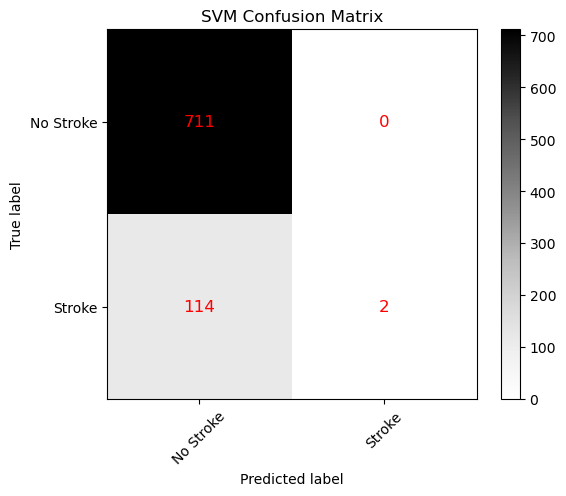

In [14]:
plt.figure()
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Greys)  # Use a light color scheme, such as Greys
plt.title('SVM Confusion Matrix')
plt.colorbar()

tick_marks = [0, 1]
plt.xticks(tick_marks, ['No Stroke', 'Stroke'], rotation=45)
plt.yticks(tick_marks, ['No Stroke', 'Stroke'])
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Display each value in its respective box
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='red', size=12)  # Use black text for visibility

plt.show()

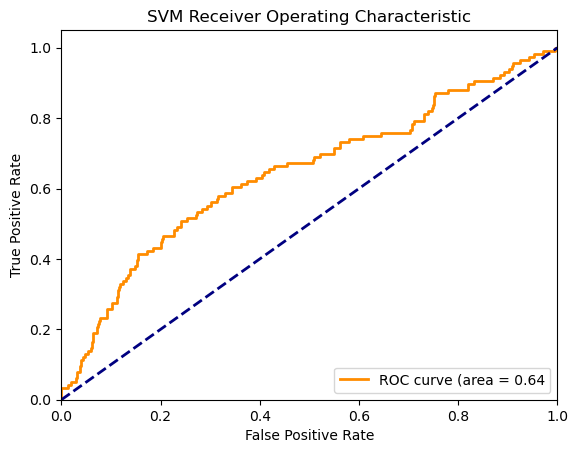

In [15]:
# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM Receiver Operating Characteristic')
plt.legend(loc='lower right')

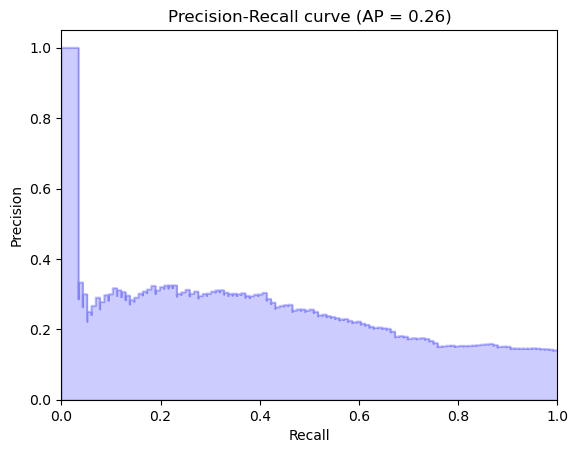

In [17]:
from sklearn.metrics import precision_recall_curve, average_precision_score
# 2. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)

plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve (AP = {:.2f})'.format(average_precision))
plt.show()

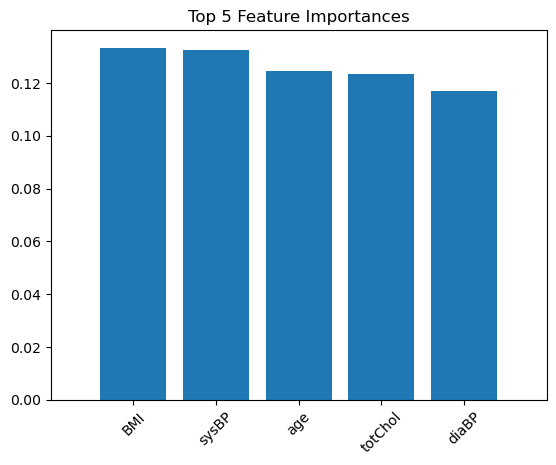

In [18]:
# 4. Feature Importance
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 5  # Select the top N important features to visualize

plt.figure()
plt.title("Top {} Feature Importances".format(top_n))
plt.bar(range(top_n), importances[indices][:top_n], align="center")
plt.xticks(range(top_n), X.columns[indices][:top_n], rotation=45)
plt.xlim([-1, top_n])
plt.show()

In [19]:
# 5. Cross-Validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)

Cross-Validation Scores: [0.85779123 0.85627837 0.85476551 0.85627837 0.85606061]


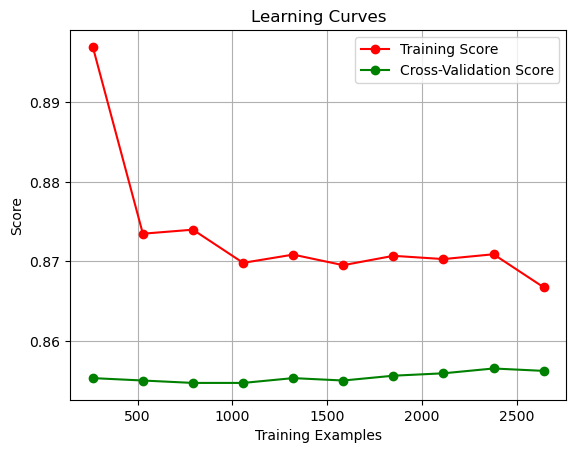

In [20]:
from sklearn.model_selection import learning_curve

# 6. Learning Curves
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5
)

plt.figure()
plt.title("Learning Curves")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.grid()
plt.plot(train_sizes, np.mean(train_scores, axis=1), "o-", color="r", label="Training Score")
plt.plot(train_sizes, np.mean(test_scores, axis=1), "o-", color="g", label="Cross-Validation Score")
plt.legend(loc="best")
plt.show()

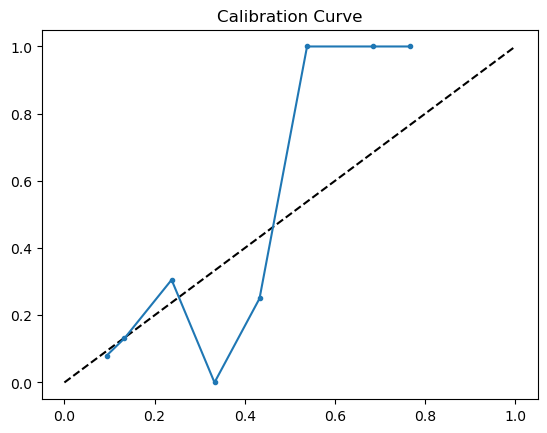

In [21]:
# 7. Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
plt.figure()
plt.plot([0, 1], [0, 1], "k--")
plt.plot(prob_pred, prob_true, marker=".")
plt.title("Calibration Curve")
plt.show()